In [4]:
%cd /home/plent/Documenten/Gitlab/NeuralODEs/jax_neural_odes

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from adjustText import adjust_text
import re

/home/plent/Documenten/Gitlab/NeuralODEs/jax_neural_odes


In [5]:
#model information (number of parameters and state variables)
n_parameter={"Borghans_BiophysChem1997":24,
             "Beer_MolBioSystems2014":12,
             "Brannmark_JBC2010":18,
             "Zheng_PNAS2012":62,
             "mosbacher2022_mixed_Hog1_phosphorylation_l2v4":280,
             "Isensee_JCB2018":63,
             "Hass_PONE2017":37,
            "Palani2011":15,
            "Sneyd_PNAS2002":16,
            "Kinetic_glycolysis_assay_model":13,
            "Fujita_SciSignal2010":26,
            "Messiha2013":192,
            "Raia_CancerResearch":45,
            "Weber_BMC2015":53,
            "Crauste_CellSystems2017":16,
            "Fiedler_BMC2016":24,
            "Smallbone2013_SerineBiosynthesis":10,
            "Bruno_JExpBio2016":10,
            "Becker_Science2010":17,
            "Ray2013":20,
            "Chassagnole2002":117,
            "Bertozzi2020":36,
            "Schwen_PONE2014":19,
            "Garde2020":6,
            "Smallbone2011_TrehaloseBiosynthesis":52,
            "Elowitz_Nature2000":22}

n_state_variables={"Borghans_BiophysChem1997":3,
                                "Beer_MolBioSystems2014":4,
             "Brannmark_JBC2010":9,
             "Zheng_PNAS2012":15,
             "mosbacher2022_mixed_Hog1_phosphorylation_l2v4":95,
             "Isensee_JCB2018":25,
             "Hass_PONE2017":9,
                  "Palani2011":5,
                  "Sneyd_PNAS2002":6,
                  "Kinetic_glycolysis_assay_model":12,
                  "Fujita_SciSignal2010":26,
                  "Messiha2013":28,
                  "Raia_CancerResearch":14,
                  "Weber_BMC2015":7,
                  "Crauste_CellSystems2017":5,
                  "Fiedler_BMC2016":6,
                  "Smallbone2013_SerineBiosynthesis":2,
                  "Bruno_JExpBio2016":6,
                  "Becker_Science2010":6,
                  "Ray2013":6,
                  "Chassagnole2002":36,
                  "Bertozzi2020":3,
                  "Schwen_PONE2014":11,
                  "Garde2020":6,
                  "Smallbone2011_TrehaloseBiosynthesis":6,
                  "Elowitz_Nature2000":8}

literature_names={"Borghans_BiophysChem1997":'Borghans et. al (1997)',
                "Beer_MolBioSystems2014":"Beer et. al (2014)",
                "Brannmark_JBC2010":"Brannmark et. al (2010)",
                "Zheng_PNAS2012":"Zheng et. al (2012)",
                "mosbacher2022_mixed_Hog1_phosphorylation_l2v4":"Mosbacher et. al (2023)",
                "Isensee_JCB2018":"Isensee et. al (2018)",
                "Hass_PONE2017":"Hass et. al (2017)",
                  "Palani2011":'Palani et. al (2011)',
                  "Sneyd_PNAS2002":'Sneyd et. al (2002)',
                  "Kinetic_glycolysis_assay_model":'Nitin et. al (2013)',
                  "Fujita_SciSignal2010":'Fujita et. al (2010)',
                  "Messiha2013":'Messiha et. al (2014)',
                  "Raia_CancerResearch":'Raia et. al (2011)',
                  "Weber_BMC2015":'Weber et. al (2015)',
                  "Crauste_CellSystems2017":'Crauste et. al (2017)',
                  "Fiedler_BMC2016":'Fiedler et. al (2016)',
                  "Smallbone2013_SerineBiosynthesis":'Smallbone et. al (2013)',
                  "Bruno_JExpBio2016":'Bruno et. al (2016)',
                  "Becker_Science2010":'Becker et. al (2010)',
                  "Ray2013":'Ray et. al (2013)',
                  "Chassagnole2002":'Chassagnole et. al (2002)',
                  "Bertozzi2020":'Bertozzi et. al (2020)',
                  "Schwen_PONE2014":'Schwen et. al (2015)',
                  "Garde2020":'Garde et. al (2020)',
                  "Smallbone2011_TrehaloseBiosynthesis":'Smallbone et. al (2011)',
                  "Elowitz_Nature2000":'Elowitz et. al (2000)'}


def retrieve_convergence_results(results_dir,file_list):
    # file_list

    loss_dfs={}
    params_dfs={}
    norms_dfs={}
    for file in file_list:
        if "losses" in file:
            loss_data=pd.read_csv(results_dir+file,index_col=0)
            loss_dfs[file]=loss_data
        if "parameters" in file:
            params_data=pd.read_csv(results_dir+file,index_col=0)
            params_dfs[file]=params_data
        if "norms" in file:
            norms_data=pd.read_csv(results_dir+file,index_col=0)
            norms_dfs[file]=norms_data
    return loss_dfs,params_dfs,norms_dfs


In [ ]:
from scipy.stats import gstd
from statistics import geometric_mean


def geometric_mean(loss_df):
    """geometric mean loss dataframe"""
    mean=[]
    for i in range(np.shape(loss_df)[0]):
        loss_df_i=loss_df[i,:
        ]
        loss_df_i=loss_df_i[~np.isnan(loss_df_i)]
        loss_df_i=loss_df_i[loss_df_i!=-1]
        geometric_mean_i=2**np.mean(np.log2(loss_df_i))

        mean.append(geometric_mean_i)
    return mean


bounds=["bounds_2.csv","bounds_5.csv","bounds_10.csv","bounds_50.csv","bounds_100.csv"]
colors=["#00468BFF","#ED0000FF","#925E9FFF","#0099B4FF","#AD002AFF"]

bounds_legend_name=["[$1/2*\\theta_{true},2*\\theta_{true}]$","[$1/5*\\theta_{true},5*\\theta_{true}]$",
                                                            "[$1/10*\\theta_{true},10*\\theta_{true}]$",
                                                            "[$1/50*\\theta_{true},50*\\theta_{true}]$","[$1/100*\\theta_{true},100*\\theta_{true}]$"]



model_names=list(literature_names.keys())
model_names=
# model_names_subset=['Borghans_BiophysChem1997']
for model_name in model_names:
    results_dir="results/EXP1_initialization_bounds_lhs_V2/"+model_name+"/"
    file_list=os.listdir(results_dir)
    loss_dfs,params_dfs,norms_dfs=retrieve_convergence_results(results_dir,file_list)


    fig,ax=plt.subplots(figsize=(4,4))

    for k,bound in enumerate(bounds):
        for key in list(loss_dfs.keys()):
            if "run_2" in key and bound in key:
                loss_df_bound=np.array(loss_dfs[key])

                # # Identify the parameter indices where no failures occurred (i.e., where loss is not -1)
                # The result is a list of column indices (parameters) where no failures are recorded.

                params_with_no_fails=np.where(loss_df_bound!=-1)[1]
                for i in params_with_no_fails:
                    temp=loss_df_bound[:,i]

                    temp2=temp[~np.isnan(temp)]

                    if len(temp2)>0 and np.abs(temp2[-1])<0.001:
                        temp[np.isnan(temp)]=0.001
                    
                    loss_df_bound[:,i]=temp

                mean=geometric_mean(loss_df_bound)
                
                # ax.plot(loss_df_bound,c=colors[k],alpha=0.1)
                ax.plot(mean,c=colors[k],linewidth=4,label=bounds_legend_name[k])

    plt.axhline(1e-3,linestyle="--",c="black")
    ax.set_ylabel("Log loss function")
    ax.set_yscale('log')
    ax.set_xlabel("Iterations")
    ax.set_title(literature_names[model_name])
    # plt.ylim(0.001,8)            
    # fig.legend(bbox_to_anchor=(0.8, 1),loc="upper left")
    # ax.legend(loc='upper left', bbox_to_anchor=(-0.2, -0.2),
    #        ncol=2,fontsize=10)
    # fig.tight_layout()
    # fig.show()    
    save_model="figures/lossplots_exp1/"+model_name+"_loss_plots"

    plt.savefig(save_model+".png",bbox_inches="tight")
    plt.savefig(save_model+".svg",bbox_inches="tight")

In [101]:
# a simple sbml model

from source.load_sbml.sbml_load import *
from source.load_sbml.sbml_model import SBMLModel








17:35:05,632 - source.load_sbml.sbml_model - INFO - No internal inconsistencies found
17:35:05,633 - source.load_sbml.sbml_model - INFO - Model loaded.
17:35:05,634 - source.load_sbml.sbml_model - INFO -  number of species: 6
17:35:05,634 - source.load_sbml.sbml_model - INFO -  number of reactions: 10
17:35:05,634 - source.load_sbml.sbml_model - INFO -  number of global parameters: 6
17:35:05,635 - source.load_sbml.sbml_model - INFO -  number of constant boundary metabolites: 0
17:35:05,635 - source.load_sbml.sbml_model - INFO -  number of lambda function definitions: 10
17:35:05,636 - source.load_sbml.sbml_model - INFO -  number of assignment rules: 0


In [209]:
literature_names

{'Borghans_BiophysChem1997': 'Borghans et. al (1997)',
 'Beer_MolBioSystems2014': 'Beer et. al (2014)',
 'Brannmark_JBC2010': 'Brannmark et. al (2010)',
 'Zheng_PNAS2012': 'Zheng et. al (2012)',
 'mosbacher2022_mixed_Hog1_phosphorylation_l2v4': 'Mosbacher et. al (2023)',
 'Isensee_JCB2018': 'Isensee et. al (2018)',
 'Hass_PONE2017': 'Hass et. al (2017)',
 'Palani2011': 'Palani et. al (2011)',
 'Sneyd_PNAS2002': 'Sneyd et. al (2002)',
 'Kinetic_glycolysis_assay_model': 'Nitin et. al (2013)',
 'Fujita_SciSignal2010': 'Fujita et. al (2010)',
 'Messiha2013': 'Messiha et. al (2014)',
 'Raia_CancerResearch': 'Raia et. al (2011)',
 'Weber_BMC2015': 'Weber et. al (2015)',
 'Crauste_CellSystems2017': 'Crauste et. al (2017)',
 'Fiedler_BMC2016': 'Fiedler et. al (2016)',
 'Smallbone2013_SerineBiosynthesis': 'Smallbone et. al (2013)',
 'Bruno_JExpBio2016': 'Bruno et. al (2016)',
 'Becker_Science2010': 'Becker et. al (2010)',
 'Ray2013': 'Ray et. al (2013)',
 'Chassagnole2002': 'Chassagnole et. al 

17:03:51,899 - source.load_sbml.sbml_model - INFO - No internal inconsistencies found
17:03:51,900 - source.load_sbml.sbml_model - INFO - Model loaded.
17:03:51,900 - source.load_sbml.sbml_model - INFO -  number of species: 6
17:03:51,901 - source.load_sbml.sbml_model - INFO -  number of reactions: 10
17:03:51,901 - source.load_sbml.sbml_model - INFO -  number of global parameters: 6
17:03:51,901 - source.load_sbml.sbml_model - INFO -  number of constant boundary metabolites: 0
17:03:51,902 - source.load_sbml.sbml_model - INFO -  number of lambda function definitions: 10
17:03:51,902 - source.load_sbml.sbml_model - INFO -  number of assignment rules: 0
0.000995259362774
17:03:56,547 - jax._src.callback - ERROR - jax.pure_callback failed
Traceback (most recent call last):
  File "/home/plent/anaconda3/envs/jax_env/lib/python3.12/site-packages/jax/_src/callback.py", line 77, in pure_callback_impl
    return callback(*args)
           ^^^^^^^^^^^^^^^
  File "/home/plent/anaconda3/envs/jax

XlaRuntimeError: INTERNAL: Generated function failed: CpuCallback error: EqxRuntimeError: The maximum number of solver steps was reached. Try increasing `max_steps`.

At:
  /home/plent/anaconda3/envs/jax_env/lib/python3.12/site-packages/equinox/_errors.py(70): raises
  /home/plent/anaconda3/envs/jax_env/lib/python3.12/site-packages/jax/_src/callback.py(65): __call__
  /home/plent/anaconda3/envs/jax_env/lib/python3.12/site-packages/jax/_src/callback.py(80): pure_callback_impl
  /home/plent/anaconda3/envs/jax_env/lib/python3.12/site-packages/jax/_src/callback.py(219): _callback
  /home/plent/anaconda3/envs/jax_env/lib/python3.12/site-packages/jax/_src/interpreters/mlir.py(2466): _wrapped_callback
  /home/plent/anaconda3/envs/jax_env/lib/python3.12/site-packages/jax/_src/interpreters/pxla.py(1205): __call__
  /home/plent/anaconda3/envs/jax_env/lib/python3.12/site-packages/jax/_src/profiler.py(335): wrapper
  /home/plent/anaconda3/envs/jax_env/lib/python3.12/site-packages/jax/_src/pjit.py(1427): _pjit_call_impl_python
  /home/plent/anaconda3/envs/jax_env/lib/python3.12/site-packages/jax/_src/pjit.py(1471): call_impl_cache_miss
  /home/plent/anaconda3/envs/jax_env/lib/python3.12/site-packages/jax/_src/pjit.py(1494): _pjit_call_impl
  /home/plent/anaconda3/envs/jax_env/lib/python3.12/site-packages/jax/_src/core.py(913): process_primitive
  /home/plent/anaconda3/envs/jax_env/lib/python3.12/site-packages/jax/_src/core.py(425): bind_with_trace
  /home/plent/anaconda3/envs/jax_env/lib/python3.12/site-packages/jax/_src/core.py(2788): bind
  /home/plent/anaconda3/envs/jax_env/lib/python3.12/site-packages/jax/_src/pjit.py(176): _python_pjit_helper
  /home/plent/anaconda3/envs/jax_env/lib/python3.12/site-packages/jax/_src/pjit.py(298): cache_miss
  /home/plent/anaconda3/envs/jax_env/lib/python3.12/site-packages/jax/_src/traceback_util.py(179): reraise_with_filtered_traceback
  /tmp/ipykernel_68023/3344698821.py(40): <module>
  /home/plent/anaconda3/envs/jax_env/lib/python3.12/site-packages/IPython/core/interactiveshell.py(3577): run_code
  /home/plent/anaconda3/envs/jax_env/lib/python3.12/site-packages/IPython/core/interactiveshell.py(3517): run_ast_nodes
  /home/plent/anaconda3/envs/jax_env/lib/python3.12/site-packages/IPython/core/interactiveshell.py(3334): run_cell_async
  /home/plent/anaconda3/envs/jax_env/lib/python3.12/site-packages/IPython/core/async_helpers.py(129): _pseudo_sync_runner
  /home/plent/anaconda3/envs/jax_env/lib/python3.12/site-packages/IPython/core/interactiveshell.py(3130): _run_cell
  /home/plent/anaconda3/envs/jax_env/lib/python3.12/site-packages/IPython/core/interactiveshell.py(3075): run_cell
  /home/plent/anaconda3/envs/jax_env/lib/python3.12/site-packages/ipykernel/zmqshell.py(549): run_cell
  /home/plent/anaconda3/envs/jax_env/lib/python3.12/site-packages/ipykernel/ipkernel.py(446): do_execute
  /home/plent/anaconda3/envs/jax_env/lib/python3.12/site-packages/ipykernel/kernelbase.py(778): execute_request
  /home/plent/anaconda3/envs/jax_env/lib/python3.12/site-packages/ipykernel/ipkernel.py(359): execute_request
  /home/plent/anaconda3/envs/jax_env/lib/python3.12/site-packages/ipykernel/kernelbase.py(437): dispatch_shell
  /home/plent/anaconda3/envs/jax_env/lib/python3.12/site-packages/ipykernel/kernelbase.py(534): process_one
  /home/plent/anaconda3/envs/jax_env/lib/python3.12/site-packages/ipykernel/kernelbase.py(545): dispatch_queue
  /home/plent/anaconda3/envs/jax_env/lib/python3.12/asyncio/events.py(88): _run
  /home/plent/anaconda3/envs/jax_env/lib/python3.12/asyncio/base_events.py(1987): _run_once
  /home/plent/anaconda3/envs/jax_env/lib/python3.12/asyncio/base_events.py(641): run_forever
  /home/plent/anaconda3/envs/jax_env/lib/python3.12/site-packages/tornado/platform/asyncio.py(205): start
  /home/plent/anaconda3/envs/jax_env/lib/python3.12/site-packages/ipykernel/kernelapp.py(739): start
  /home/plent/anaconda3/envs/jax_env/lib/python3.12/site-packages/traitlets/config/application.py(1075): launch_instance
  /home/plent/anaconda3/envs/jax_env/lib/python3.12/site-packages/ipykernel_launcher.py(18): <module>
  <frozen runpy>(88): _run_code
  <frozen runpy>(198): _run_module_as_main


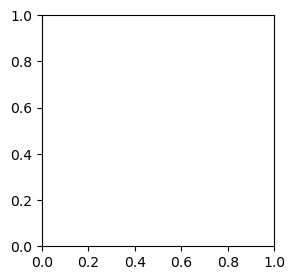

In [211]:


results_dir="results/EXP1_initialization_bounds_lhs_V2/"
model_name='Garde2020'
bounds="bounds_10"

filepath = f"models/sbml_models/working_models/{model_name}.xml"
model = SBMLModel(filepath)
S=model._get_stoichiometric_matrix()
JaxKmodel = jax.jit(model.get_kinetic_model())
params = get_global_parameters(model.model)
params_true = {**model.local_params, **params}

model_success_dict={}

results_dir="results/EXP1_initialization_bounds_lhs/"+model_name+"/"
file_list=os.listdir(results_dir)
loss_dfs,params_dfs,norms_dfs=retrieve_convergence_results(results_dir,file_list)


example_params=params_dfs[f'{model_name}_parameters_id_lhs_N=100run_2{bounds}.csv']
example_loss=loss_dfs[f'{model_name}_losses_id_lhs_N=100run_2{bounds}.csv']
indices=example_loss.iloc[-1,:].dropna().sort_values().keys()[0]


minimal_loss=np.inf
find_index=np.nan
for i in range(np.shape(example_loss)[1]):
    examp=example_loss.iloc[:,i].dropna().values[-1]
    if np.abs(examp)<minimal_loss:
        minimal_loss=np.abs(examp)
        
        find_index=i
print(minimal_loss)
params_test=example_params[str(find_index)].to_dict()



fig,ax=plt.subplots(figsize=(3,3))
ts=jnp.linspace(0,8000,1000)
# ys=JaxKmodel(ts=ts,y0=model.y0,params=params)
ys=JaxKmodel(ts=ts,y0=model.y0,params=params_test)
ys=pd.DataFrame(ys,columns=model.species_names)
ts_true=jnp.linspace(0,8000,10)

ys_true=JaxKmodel(ts=ts_true,y0=model.y0,params=params_true)
ys_true=pd.DataFrame(ys_true,columns=model.species_names)

colors=['#ED0000FF','#00468BFF','#925E9FFF','#AD002AFF','#ADB6B6FF',"#1B1919FF","#AD002AFF","#42540FF"]
for i,k in enumerate(ys.columns):
    try:
        ax.plot(ts,ys[k],label=k,c=colors[i])
        ax.scatter(ts_true,ys_true[k],linestyle="--",c=colors[i])
    except:
        continue
ax.legend(bbox_to_anchor=(1.04,1),loc="upper left")
ax.set_title(literature_names[model_name])
ax.set_xlabel("Time (in s)")
# ax.set_yscale("log")
ax.set_ylabel("Concentration (in mM)")
plt.savefig(f"figures/timeseries_exp1/{model_name}_timeseries_plot_{bounds}.svg",bbox_inches="tight")



In [ ]:


results_dir="results/EXP1_initialization_bounds_lhs_V2/"
model_name='Garde2020'
bounds="bounds_10"

model_success_dict={}

results_dir="results/EXP1_initialization_bounds_lhs/"+model_name+"/"
file_list=os.listdir(results_dir)
loss_dfs,params_dfs,norms_dfs=retrieve_convergence_results(results_dir,file_list)


example_params=params_dfs[f'{model_name}_parameters_id_lhs_N=100run_1{bounds}.csv']
example_loss=loss_dfs[f'{model_name}_losses_id_lhs_N=100run_1{bounds}.csv']
indices=example_loss.iloc[-1,:].dropna().sort_values().keys()[0]


minimal_loss=np.inf
find_index=np.nan
for i in range(np.shape(example_loss)[1]):
    examp=example_loss.iloc[:,i].dropna().values[-1]
    if np.abs(examp)<minimal_loss:
        minimal_loss=np.abs(examp)
        find_index=i

params_test=example_params[str(find_index)].to_dict()



fig,ax=plt.subplots(figsize=(3,3))
ts=jnp.linspace(0,15,1000)
# ys=JaxKmodel(ts=ts,y0=model.y0,params=params)
ys=JaxKmodel(ts=ts,y0=model.y0,params=params_test)
ys=pd.DataFrame(ys,columns=model.species_names)
ax.plot(ts,ys['Naive'],c="#ED0000FF")
ax.plot(ts,ys['EarlyEffector'],c="#00468BFF")
ax.plot(ts,ys['LateEffector'],c="#925E9FFF")
ax.plot(ts,ys['Memory'],c="#AD002AFF")
ax.plot(ts,ys['Pathogen'],c="#ADB6B6FF")

ts=jnp.linspace(0,15,1000)
ys=JaxKmodel(ts=ts,y0=model.y0,params=params)
ys=pd.DataFrame(ys,columns=model.species_names)
ax.plot(ts,ys['Naive'],c="black",linestyle="--")
ax.plot(ts,ys['EarlyEffector'],c="black",linestyle="--")
ax.plot(ts,ys['LateEffector'],c="black",linestyle="--")
ax.plot(ts,ys['Memory'],c="black",linestyle="--")
ax.plot(ts,ys['Pathogen'],c="black",linestyle="--")


In [ ]:
# example_params=example_params.loc[indices]
# top_fit=example_params[indices]


# params_test=top5_fits.iloc[:,i].to_dict()
# ts=jnp.linspace(0,15,1000)
# # ys=JaxKmodel(ts=ts,y0=model.y0,params=params)
# ys=JaxKmodel(ts=ts,y0=model.y0,params=params_test)
# ys=pd.DataFrame(ys,columns=model.species_names)
# ax.plot(ts,ys['Naive'],c="#ED0000FF")
# ax.plot(ts,ys['EarlyEffector'],c="#00468BFF")
# ax.plot(ts,ys['LateEffector'],c="#925E9FFF")
# ax.plot(ts,ys['Memory'],c="#AD002AFF")
# ax.plot(ts,ys['Pathogen'],c="#ADB6B6FF")


# ts=jnp.linspace(0,15,1000)
# ys=JaxKmodel(ts=ts,y0=model.y0,params=params)
# ys=pd.DataFrame(ys,columns=model.species_names)
# ax.plot(ts,ys['Naive'],c="black",linestyle="--")
# ax.plot(ts,ys['EarlyEffector'],c="black",linestyle="--")
# ax.plot(ts,ys['LateEffector'],c="black",linestyle="--")
# ax.plot(ts,ys['Memory'],c="black",linestyle="--")
# ax.plot(ts,ys['Pathogen'],c="black",linestyle="--")

# ax.scatter(ts2,ys2['Naive'],c="#ED0000FF",label="Naive")
# ax.scatter(ts2,ys2['EarlyEffector'],c="#00468BFF",label="EarlyEffector")
# ax.scatter(ts2,ys2['LateEffector'],c="#925E9FFF",label="LateEffector")
# ax.scatter(ts2,ys2['Memory'],c="#AD002AFF",label="Memory")
# ax.scatter(ts2,ys2['Pathogen'],c="#ADB6B6FF",label="Pathogen")
# ax.set_yscale("symlog")
# ax.set_ylabel("Log concentration (in mM)")
# ax.set_xlabel("Time (in s)")
# # ax.legend(bbox_to_anchor=(1.04,1),loc="upper left")
# ax.set_title("$[1/2*\\theta_{true},2*\\theta_{true}]$")